### Projeto de spark  

- dataset usado: credit card fraud dettection
- focado em tratar o problema de dados desbalanceados -> material usado: https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253

In [52]:
# imports necessarios 
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import VectorAssembler 

In [53]:
# criando sessao no spark 
spark = SparkSession.builder.appName('credit-card').getOrCreate()

In [54]:
# carregando o dataset 
df = spark.read.csv('datasets/creditcard.csv', inferSchema=True, header=True)

In [55]:
df.describe().show()

+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|summary|             Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|   

In [56]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [57]:
df.columns

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [58]:
# visualização de algumas colunas 
cols = df.select(['Time', 'Amount', 'Class'])
cols.show()

+----+------+-----+
|Time|Amount|Class|
+----+------+-----+
| 0.0|149.62|    0|
| 0.0|  2.69|    0|
| 1.0|378.66|    0|
| 1.0| 123.5|    0|
| 2.0| 69.99|    0|
| 2.0|  3.67|    0|
| 4.0|  4.99|    0|
| 7.0|  40.8|    0|
| 7.0|  93.2|    0|
| 9.0|  3.68|    0|
|10.0|   7.8|    0|
|10.0|  9.99|    0|
|10.0| 121.5|    0|
|11.0|  27.5|    0|
|12.0|  58.8|    0|
|12.0| 15.99|    0|
|12.0| 12.99|    0|
|13.0|  0.89|    0|
|14.0|  46.8|    0|
|15.0|   5.0|    0|
+----+------+-----+
only showing top 20 rows



In [59]:
# analisando quantidade de transacoes fraudulentas ou nao (0 -> comum,  1->fraudulenta)
counts = df.groupBy('Class').count()
counts.show()


+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



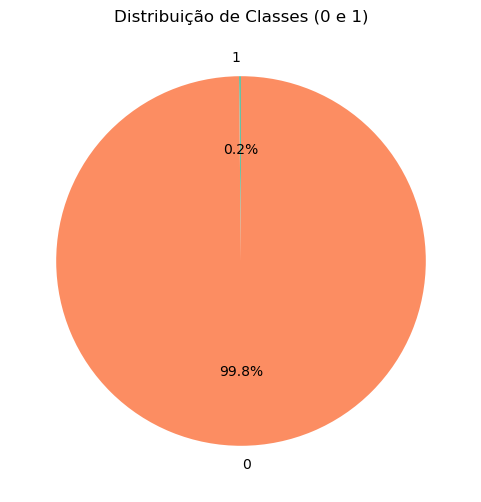

In [60]:
# visualização da distribuição dos dados 
class_counts = df.groupBy("Class").count().toPandas()
plt.figure(figsize=(6, 6))
plt.pie(class_counts['count'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title("Distribuição de Classes (0 e 1)")
plt.show()

É possível perceber que a base de dados está desbalanceada, tem muito mais transações comuns do que fraudulentas.

### Transformação dos dados para poder usar nos modelos 

Fazendo a transformação em vesctor para poder dividir e depois jogar no modelo


In [61]:
assembler = VectorAssembler(inputCols=['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'], outputCol='features')

In [62]:
output = assembler.transform(df)

In [63]:
final_data = output.select('features', 'Class')

In [64]:
final_data.show()

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[0.0,-1.359807133...|    0|
|[0.0,1.1918571113...|    0|
|[1.0,-1.358354061...|    0|
|[1.0,-0.966271711...|    0|
|[2.0,-1.158233093...|    0|
|[2.0,-0.425965884...|    0|
|[4.0,1.2296576345...|    0|
|[7.0,-0.644269442...|    0|
|[7.0,-0.894286082...|    0|
|[9.0,-0.338261752...|    0|
|[10.0,1.449043781...|    0|
|[10.0,0.384978215...|    0|
|[10.0,1.249998742...|    0|
|[11.0,1.069373587...|    0|
|[12.0,-2.79185476...|    0|
|[12.0,-0.75241704...|    0|
|[12.0,1.103215435...|    0|
|[13.0,-0.43690507...|    0|
|[14.0,-5.40125766...|    0|
|[15.0,1.492935976...|    0|
+--------------------+-----+
only showing top 20 rows



In [65]:
# dividindo em conjunto de treino e teste 
train, test = final_data.randomSplit([0.7, 0.3])

In [66]:
test.groupBy('Class').count().show()

+-----+-----+
|Class|count|
+-----+-----+
|    1|  146|
|    0|85080|
+-----+-----+



In [67]:
train.groupBy('Class').count().show()

+-----+------+
|Class| count|
+-----+------+
|    1|   346|
|    0|199235|
+-----+------+



Dados muito desbalanceados podem afetar a acurácia do modelo, existem técnicas para tratar o desbalanceamento. Oversampling, undersampling, smote. 

### Criação e treinamento dos modelos

In [68]:
# testando acurácia sem usar nenhuma tecnica para tratamento de dados desbalanceados 
from pyspark.ml.classification import LogisticRegression


In [69]:
lr_class = LogisticRegression(labelCol='Class')

In [70]:
fit_class = lr_class.fit(train)

In [71]:
training = fit_class.summary

In [72]:
training.predictions.describe().show()

+-------+--------------------+--------------------+
|summary|               Class|          prediction|
+-------+--------------------+--------------------+
|  count|              199581|              199581|
|   mean|0.001733631958954...|0.001217550768860...|
| stddev|0.041600903241722026| 0.03487225877575607|
|    min|                 0.0|                 0.0|
|    max|                 1.0|                 1.0|
+-------+--------------------+--------------------+



In [73]:
results = fit_class.transform(test)

###  Avaliação do modelo

In [74]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [75]:
eval = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='accuracy')
acc = eval.evaluate(results)
print(acc)

0.9991786544012391


Acurácia de 99%, um valor esperado quando se trata de dados desbalanceados, ele pode estar pegando a parcela maior de uma classe, mesmo sendo dividido em treino e teste, a classe 0 vai predominar.

In [76]:
evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="recallByLabel")
recall = evaluator.evaluate(results)
print(f"Recall: {recall}")

Recall: 0.9998001880582981


### Usando técnica de oversampling  

A técnica consiste em aumentar o conjunto de dados não predominantes fazendo a multiplicação de dados já existentes, até chegar na mesma proporção dos dados predominantes 

In [77]:
# tratando a classes balanceada usando o oversampling
from pyspark.sql.functions import col, explode, array, lit

major_df = df.filter(col("Class") == 0)
minor_df = df.filter(col("Class") == 1)
ratio = int(major_df.count()/minor_df.count()) # quantidade de vezes que precisamos multiplicar cada amostra
print(f'ratio: {ratio}')

ratio: 577


In [78]:
a = range(ratio)
# criando as linhas duplicadas e dropando a coluna dummy que serve de auxiliar 
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
combined_df = major_df.unionAll(oversampled_df) # combinando as amostras geradas e as que ja tinham
combined_df.select('Time', 'Amount', 'Class').show()

+----+------+-----+
|Time|Amount|Class|
+----+------+-----+
| 0.0|149.62|    0|
| 0.0|  2.69|    0|
| 1.0|378.66|    0|
| 1.0| 123.5|    0|
| 2.0| 69.99|    0|
| 2.0|  3.67|    0|
| 4.0|  4.99|    0|
| 7.0|  40.8|    0|
| 7.0|  93.2|    0|
| 9.0|  3.68|    0|
|10.0|   7.8|    0|
|10.0|  9.99|    0|
|10.0| 121.5|    0|
|11.0|  27.5|    0|
|12.0|  58.8|    0|
|12.0| 15.99|    0|
|12.0| 12.99|    0|
|13.0|  0.89|    0|
|14.0|  46.8|    0|
|15.0|   5.0|    0|
+----+------+-----+
only showing top 20 rows



In [79]:
combined_df.groupBy('Class').count().show()

+-----+------+
|Class| count|
+-----+------+
|    0|284315|
|    1|283884|
+-----+------+



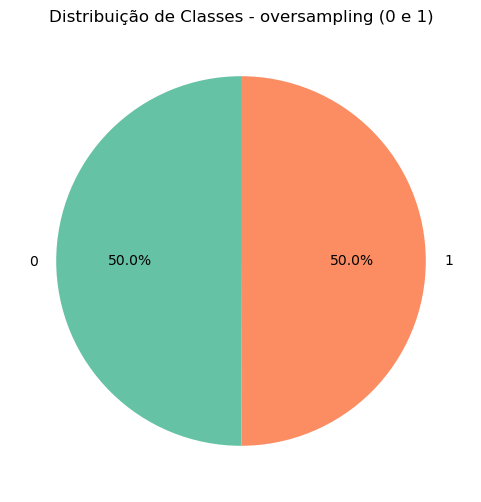

In [80]:
class_counts = combined_df.groupBy("Class").count().toPandas()
plt.figure(figsize=(6, 6))
plt.pie(class_counts['count'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title("Distribuição de Classes - oversampling (0 e 1)")
plt.show()

Técnica do oversampling conseguiu balancear os dados 

In [81]:
# aplicando o vector assembler na nova base oversampled
assembler_over = VectorAssembler(inputCols=['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'], outputCol='features')
output_over = assembler_over.transform(combined_df)
over_data = output_over.select('features', 'Class')
over_data.show()

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[0.0,-1.359807133...|    0|
|[0.0,1.1918571113...|    0|
|[1.0,-1.358354061...|    0|
|[1.0,-0.966271711...|    0|
|[2.0,-1.158233093...|    0|
|[2.0,-0.425965884...|    0|
|[4.0,1.2296576345...|    0|
|[7.0,-0.644269442...|    0|
|[7.0,-0.894286082...|    0|
|[9.0,-0.338261752...|    0|
|[10.0,1.449043781...|    0|
|[10.0,0.384978215...|    0|
|[10.0,1.249998742...|    0|
|[11.0,1.069373587...|    0|
|[12.0,-2.79185476...|    0|
|[12.0,-0.75241704...|    0|
|[12.0,1.103215435...|    0|
|[13.0,-0.43690507...|    0|
|[14.0,-5.40125766...|    0|
|[15.0,1.492935976...|    0|
+--------------------+-----+
only showing top 20 rows



In [82]:
# separando em teste e treino 
train_over, test_over = over_data.randomSplit([0.7, 0.3])

### Criação e treinamento dos modelos

In [83]:
# aplicando no modelo 
# usando logistic regression primeiro 
lr = LogisticRegression(labelCol='Class')

# fit the model 
lr_fitted = lr.fit(train_over)
lr_sum = lr_fitted.summary
training_lr = lr_sum.predictions.describe().show()

+-------+-------------------+-------------------+
|summary|              Class|         prediction|
+-------+-------------------+-------------------+
|  count|             398397|             398397|
|   mean|0.49950928345343965|0.47176560064458317|
| stddev| 0.5000003867128575| 0.4992028086944246|
|    min|                0.0|                0.0|
|    max|                1.0|                1.0|
+-------+-------------------+-------------------+



In [84]:
results_over = lr_fitted.transform(test_over)
results_over.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|Class|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,-1.359807133...|    0|[1.03664472610892...|[0.73820208508282...|       0.0|
|[0.0,1.1918571113...|    0|[2.92396365821828...|[0.94901841230261...|       0.0|
|[10.0,1.249998742...|    0|[3.68670938812913...|[0.97555806526637...|       0.0|
|[12.0,-0.75241704...|    0|[3.54850501715010...|[0.97203681938985...|       0.0|
|[14.0,-5.40125766...|    0|[-0.2866213094015...|[0.42883122693785...|       1.0|
|[16.0,0.694884775...|    0|[2.60383915659384...|[0.93110825290897...|       0.0|
|[22.0,-1.94652513...|    0|[5.30746819024917...|[0.99506997101638...|       0.0|
|[24.0,1.237429030...|    0|[2.58324496372504...|[0.92977543846533...|       0.0|
|[32.0,-2.00887179...|    0|[5.1177774125319,...|[0.99404633848339...|       0.0|
|[35.0,1.1993559

In [87]:
# usando outros metodos de classificacao 
 
rfc = RandomForestClassifier(labelCol='Class', featuresCol='features', numTrees=100)
dtc = DecisionTreeClassifier(labelCol='Class', featuresCol='features')
gbt = GBTClassifier(labelCol='Class', featuresCol='features')


In [88]:
# treinando os modelos 

rfc_train = rfc.fit(train_over)
dtc_train = dtc.fit(train_over)
gbt_train = gbt.fit(train_over)

In [89]:
# previsoes 

rfc_preds = rfc_train.transform(test_over)
dtc_preds = dtc_train.transform(test_over)
gbt_preds = gbt_train.transform(test_over)

In [90]:
rfc_preds.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|Class|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,-1.359807133...|    0|[92.3224948228627...|[0.92322494822862...|       0.0|
|[0.0,1.1918571113...|    0|[92.9972826214687...|[0.92997282621468...|       0.0|
|[10.0,1.249998742...|    0|[92.5882275878972...|[0.92588227587897...|       0.0|
|[12.0,-0.75241704...|    0|[91.5350094305990...|[0.91535009430599...|       0.0|
|[14.0,-5.40125766...|    0|[78.7570776382803...|[0.78757077638280...|       0.0|
|[16.0,0.694884775...|    0|[92.6656203074111...|[0.92665620307411...|       0.0|
|[22.0,-1.94652513...|    0|[91.9591018073105...|[0.91959101807310...|       0.0|
|[24.0,1.237429030...|    0|[92.5334414914458...|[0.92533441491445...|       0.0|
|[32.0,-2.00887179...|    0|[92.4941896119046...|[0.92494189611904...|       0.0|
|[35.0,1.1993559

### Avaliando métricas de cada modelo

Logistic Regression

In [97]:
eval = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='accuracy')
acc = eval.evaluate(results_over)
print(f"Acurácia LR: {acc}")

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="recallByLabel")
recall = evaluator.evaluate(results_over)
print(f"Recall LR: {recall}")

Acurácia LR: 0.9504069445589569
Recall LR: 0.9773436488030052


Ranfom Forest

In [100]:
acc_rfc = eval.evaluate(rfc_preds)
print(f'Acurácia: {acc_rfc}')

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="recallByLabel")
recall_rfc = evaluator.evaluate(rfc_preds)
print(f"Recall: {recall_rfc}")

Acurácia: 0.9530747576589204
Recall: 0.9967616961646707


Decision Tree

In [101]:
acc_dtc = eval.evaluate(dtc_preds)
print(f'Acurácia: {acc_dtc}')

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="recallByLabel")
recall_dtc = evaluator.evaluate(dtc_preds)
print(f"Recall: {recall_dtc}")

Acurácia: 0.9568202965807234
Recall: 0.977991309570071


Gradient Boosting

In [104]:
acc_gbt = eval.evaluate(gbt_preds)
print(f'Acurácia: {acc_gbt}')

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="recallByLabel")
recall_gbt = evaluator.evaluate(gbt_preds)
print(f"Recall: {recall_gbt}")

Acurácia: 0.9855596518297782
Recall: 0.9874000541679915


Um recall alto pode indicar um overfitting, o que na técnica de oversampling pode acontecer, já que estou multiplicando dados já existentes.